# About this project:

This project aims to train a neural network model to identify the presence of COVID-19 from images of Chest X-Rays. A model that works well would be useful for accelerating the identification of infected individuals, especially in countries where hospitals are overwhelmed and lacking trained doctors to make diagnoses.


## Dataset information:


The dataset was downloaded from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset


## Content

The dataset contains ~5800 jpeg images of Chest X-Rays of Healthy patients, as well as patients affected with Pneumonia. The pneumonia X-Rays contain cases of bacterial infections as well as viral infections, such as SARS (Severe Acute Respiratory Syndrome ) ,Streptococcus & ARDS (Acute Respiratory Distress Syndrome).


## Acknowledgements

This analysis is made possible by the dataset compiled by Joseph Paul Cohen. Postdoctoral Fellow, Mila, University of Montreal.

Original Source :- https://github.com/ieee8023/covid-chestxray-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#For organizing image folders
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization

# Import data

In [4]:
os.mkdir('./Data/')

In [ ]:
os.move()

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Kesterchia/Institute-of-Data/master/Projects/Project%203/Chest_xray_Corona_Metadata.csv', index_col = 0)

df_train = df[df['Dataset_type'] == 'TRAIN']
df_test = df[df['Dataset_type'] == 'TEST']

print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

Training data shape: (5286, 5)
Testing data shape: (624, 5)


In [3]:
#Looking at metadata:

df_train.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
#The dataset also contains a csv file of the summary counts:

summary = pd.read_csv('https://raw.githubusercontent.com/Kesterchia/Institute-of-Data/master/Projects/Project%203/Chest_xray_Corona_dataset_Summary.csv', index_col = 0)

summary

All the images will be used for analysis except the non-viral, Stress-Smoking images, as there are only 2 of those.

# Preparing the image data by rearranging the directories:

### Making new folders for Healthy (Pneumonia-free) X-Rays:

In [ ]:
#Get list of all filenames

all_filenames_test = os.listdir('./Pictures/test')
all_filenames_train = os.listdir('./Pictures/train')

#Get list of filenames for the 'Normal' or healthy X-rays

normal_filenames_test = list(df_test[df_test['Label'] == 'Normal']['X_ray_image_name'])
normal_filenames_train = list(df_train[df_train['Label'] == 'Normal']['X_ray_image_name'])

print('No. of Normal X-rays (training):',len(normal_filenames_train))
print('No. of Normal X-rays (testing):',len(normal_filenames_test))

In [ ]:
#Moving normal x-ray files to new folders:




#Move files into new folder (testing)
'''

#os.makedirs('./Pictures/test/normal')


for filename in normal_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/normal/{}'.format(filename)
               )
'''
    
#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/normal')

for filename in normal_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/normal/{}'.format(filename)
               )
               
'''

### Making new folders for Pneumonia (bacterial) infections:

In [ ]:

#Get list of filenames for the bacterial infection X-rays

bacteria_filenames_test = list(df_test[df_test['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])
bacteria_filenames_train = list(df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])

print('No. of Bacterial Infection X-rays (training):',len(bacteria_filenames_train))
print('No. of Bacterial Infection X-rays (testing):',len(bacteria_filenames_test))

In [ ]:
#Moving bacteria x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/bacteria')


for filename in bacteria_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/bacteria/{}'.format(filename)
               )

'''


#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/bacteria')

for filename in bacteria_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/bacteria/{}'.format(filename)
               )         
'''

### Making new folder for Pneumonia (Viral, COVID-19) infections:

In [ ]:

#Get list of filenames for the bacterial infection X-rays

covid_filenames_test = list(df_test[df_test['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])
covid_filenames_train = list(df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])

print('No. of COVID-19 Infection X-rays (training):',len(covid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(covid_filenames_test))


### There are no COVID-19 X-rays in the testing folder, so we will move some there

In [ ]:
#Moving covid-19 x-ray files to new folders:



#Move files into new folder (testing)

'''
# os.makedirs('./Pictures/test/covid-19')

for filename in covid_filenames_train[:8]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/test/covid-19/'
               )
'''



#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/covid-19')

for filename in covid_filenames_train[8:]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/covid-19/'
               )         
'''

### Making new folder for Pneumonia (Viral, non-COVID) infections:

In [ ]:
#Get list of filenames for the bacterial infection X-rays

virus_noncovid_filenames_test = list(df_test.loc[(df_test['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_test['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

virus_noncovid_filenames_train = list(df_train.loc[(df_train['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_train['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

print('No. of COVID-19 Infection X-rays (training):',len(virus_noncovid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(virus_noncovid_filenames_test))


In [ ]:
#Moving viral (non-covid) x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/virus(non-covid)')

for filename in virus_noncovid_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/virus(non-covid)/'
               )
'''

#Move files into new folder (training)


'''
os.makedirs('./Pictures/train/virus(non-covid)')

for filename in virus_noncovid_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/virus(non-covid)/'
               )         
'''

This is what the data folder structure for the pictures looks like now:

In [ ]:
#Visualize the picture folder

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        
            
list_files('./Pictures')

In [ ]:
#Note: There were 25 images in the training set with no metadata. They were deleted from the folder.

# Loading an example image

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [ ]:
summary

### Seeing some example images:

In [ ]:
#Getting some sample images

normal = df_train[df_train['Label'] == 'Normal']['X_ray_image_name'].iloc[0]
bacteria = df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'].iloc[0]
virus_covid = df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].iloc[10]
virus_noncovid = df_train[(df_train['Label_2_Virus_category'] != 'COVID-19')
                          &
                          (df_train['Label_1_Virus_category'] == 'Virus')]['X_ray_image_name'].iloc[0]


covid_img = load_img('./Pictures/train/covid-19/{}'.format(virus_covid))
virus_noncovid_img = load_img('./Pictures/train/virus(non-covid)/{}'.format(virus_noncovid))
bacteria_img = load_img('./Pictures/train/bacteria/{}'.format(bacteria))
normal_img = load_img('./Pictures/train/normal/{}'.format(normal))



#Plotting the images

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14,14))



ax[0][0].imshow(covid_img)
ax[0][0].set_title('Viral infection (Covid-19)')

ax[0][1].imshow(virus_noncovid_img)
ax[0][1].set_title('Viral infection (Non-covid)')

ax[1][0].imshow(bacteria_img)
ax[1][0].set_title('Bacterial infection')

ax[1][1].imshow(normal_img)
ax[1][1].set_title('Healthy')


plt.show()

# Doing image augmentation

Here we will try to artificially generate images so we can have a larger training dataset. First we decide what kind of image transformations will be appropriate, and then proceed with the generation.

In [ ]:
#Import libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img

### Horizontal image shifting

In [ ]:
img_array = img_to_array(covid_img)

img_array.shape

In [ ]:
img_array_exp = np.expand_dims(img_array, 0)

img_array_exp.shape

In [ ]:
imagegen = ImageDataGenerator(width_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

In [ ]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')

# Load images into keras dataset object

In [ ]:
from keras.preprocessing import image_dataset_from_directory

training_ds = image_dataset_from_directory(directory = './Pictures/train',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')
testing_ds = image_dataset_from_directory(directory = './Pictures/test',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')

In [19]:
testing_ds.class_names

['bacteria', 'covid-19', 'normal', 'virus(non-covid)']

### Make model

In [42]:
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, load_model
from keras.metrics import AUC, Precision, Recall

In [139]:
model = load_model('./Models/Model_three_no_augmentation')

In [43]:
'''
model = Sequential()

model.add(Conv2D(filters = 60, kernel_size = (2,2), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu')) 
model.add(MaxPool2D(pool_size = (2,2))) #Pooling to accelerate learning
model.add(Dropout(0.4)) #Dropout to prevent overfitting


model.add(Conv2D(filters = 30, kernel_size = (2,2), 
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4)) 


model.add(Conv2D(filters = 10, kernel_size = (2,2), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4))

#Flatten outputs before dense layer
model.add(Dropout(0.2))
model.add(Flatten())

#Dense layer for decision output
model.add(Dense(4, activation = 'softmax'))
'''

In [44]:
#model.compile(optimizer = 'adam',
#              loss = tf.keras.losses.CategoricalCrossentropy(),
#              metrics = ['accuracy', AUC(), Precision(), Recall()])

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 60)      300       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 60)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 127, 127, 60)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 30)      7230      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 30)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 63, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 10)       

In [109]:
# history = model.fit(training_ds, epochs = 10)

Epoch 1/10
165/165 [==============================] - 261s 2s/step - loss: 0.6326 - accuracy: 0.7727 - auc_1: 0.9483 - precision_1: 0.7909 - recall_1: 0.7504
Epoch 2/10
165/165 [==============================] - 260s 2s/step - loss: 0.6150 - accuracy: 0.7769 - auc_1: 0.9499 - precision_1: 0.7955 - recall_1: 0.7504
Epoch 3/10
165/165 [==============================] - 260s 2s/step - loss: 0.6047 - accuracy: 0.7775 - auc_1: 0.9510 - precision_1: 0.7946 - recall_1: 0.7568
Epoch 4/10
165/165 [==============================] - 267s 2s/step - loss: 0.5831 - accuracy: 0.7839 - auc_1: 0.9527 - precision_1: 0.8020 - recall_1: 0.7608
Epoch 5/10
165/165 [==============================] - 287s 2s/step - loss: 0.5688 - accuracy: 0.7839 - auc_1: 0.9534 - precision_1: 0.7991 - recall_1: 0.7616
Epoch 6/10
165/165 [==============================] - 273s 2s/step - loss: 0.5623 - accuracy: 0.7890 - auc_1: 0.9534 - precision_1: 0.8035 - recall_1: 0.7659
Epoch 7/10
165/165 [==============================] 

In [110]:
model.evaluate(testing_ds)

20/20 [==============================] - 7s 352ms/step - loss: 1.4211 - accuracy: 0.5886 - auc_1: 0.8040 - precision_1: 0.6515 - recall_1: 0.5680


[1.4210865497589111,
 0.5886076092720032,
 0.8039718866348267,
 0.6515426635742188,
 0.5680379867553711]

In [111]:
#Load main epoch history

with open('./Models/Model_three_no_augmentation/history.p', 'rb') as readingfile:
    mainhistory = pickle.load(readingfile)

In [112]:
#Unlock this cell when training the model

'''
#Update main history dictionary with new batch

for key in history.history.keys():
    mainhistory[key].extend(history.history[key])
    
print('{} new entries added to main history dictionary'.format(len(history.history['loss'])))
'''

10 new entries added to main history dictionary


In [113]:
#Save main dictionary:

'''
import pickle

with open('./Models/Model_three/history.p', 'wb') as outfile:
    pickle.dump(mainhistory, outfile)
'''

Text(0, 0.5, 'Loss (Categorical Cross-entropy)')

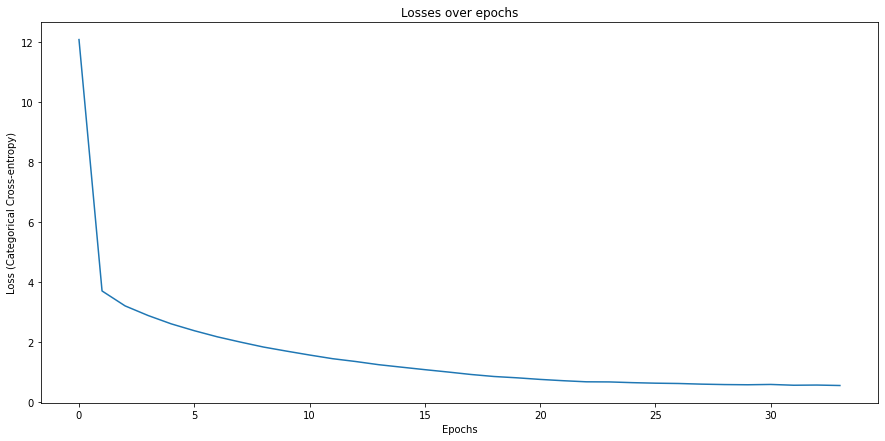

In [119]:
#Plot loss over time:

fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (15,7))

ax.plot(mainhistory['loss'])

ax.set_title('Losses over epochs')

ax.set_xlabel('Epochs')

ax.set_ylabel('Loss (Categorical Cross-entropy)')



In [137]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 255, 255, 60)      300       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 60)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 127, 127, 60)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 126, 126, 30)      7230      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 30)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 63, 30)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 10)       

In [138]:
#Save model

model.save('./Models/Model_three_no_augmentation/', overwrite = False)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./Models/Model_three_no_augmentation/assets
